# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import closs
import os
import imageio
import json
from simplegen import SIMPLESequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 6.8) Supervised Euclidean for SIMPLED with fixed image
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/6_8_euclidean'

#path_fixed = r'D:\Julian\data\SIMPLED\train\0'
#path_train = r'D:\Julian\data\SIMPLED\train'
#path_validation = r'D:\Julian\data\SIMPLED\validation'
#path_test = r'D:\Julian\data\SIMPLED\test'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/SIMPLED/train/0'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/SIMPLED/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/SIMPLED/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/SIMPLED/test'

width = 224
height = 224

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [5]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(224, 224, 2))

# Preparation
Prepare the settings for evaluating the model.

In [6]:
validation_gen = SIMPLESequence(path_validation, path_fixed,
                                batch_size=1,
                                preprocess_input=pre_une,
                                multi_channel='fixed')

eu_loss = closs.EuclideanLoss(batch_size=1, loss_type='maed')

model.compile(optimizer='adam', loss = eu_loss)
model.load_weights(store_path+'/weights.100.hdf5')

# Evaluate
Run the evaluation.

In [7]:
X, y = validation_gen[1]

In [8]:
results = model.evaluate(X,y)

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00


In [9]:
results

0.0

In [10]:
y

array([[[[ 25.,  67.],
         [210., 157.]],

        [[ 43.,  90.],
         [195., 157.]],

        [[ 62., 112.],
         [186., 157.]],

        [[ 81., 134.],
         [186., 157.]],

        [[102., 157.],
         [192., 157.]],

        [[ 27.,  67.],
         [185., 134.]],

        [[  0.,   0.],
         [  0.,   0.]],

        [[ 65., 112.],
         [161., 134.]],

        [[ 83., 134.],
         [161., 134.]],

        [[105., 157.],
         [166., 134.]],

        [[ 28.,  67.],
         [161., 112.]],

        [[ 47.,  90.],
         [147., 112.]],

        [[ 65., 112.],
         [137., 112.]],

        [[ 85., 134.],
         [138., 112.]],

        [[  0.,   0.],
         [  0.,   0.]],

        [[ 24.,  67.],
         [138.,  90.]],

        [[ 43.,  90.],
         [125.,  90.]],

        [[ 61., 112.],
         [116.,  90.]],

        [[ 80., 134.],
         [116.,  90.]],

        [[101., 157.],
         [121.,  90.]],

        [[ 16.,  67.],
         [116.,  

x: 67 y: 157
x: 90 y: 157
x: 112 y: 157
x: 135 y: 157
x: 157 y: 157
x: 67 y: 134
x: 90 y: 134
x: 112 y: 134
x: 134 y: 135
x: 157 y: 135
x: 67 y: 112
x: 90 y: 112
x: 112 y: 112
x: 134 y: 112
x: 157 y: 113
x: 67 y: 90
x: 0 y: 0
x: 111 y: 91
x: 134 y: 90
x: 157 y: 90
x: 0 y: 0
x: 89 y: 67
x: 111 y: 67
x: 134 y: 67
x: 157 y: 68


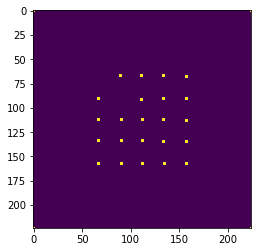

In [11]:
X, y = validation_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

warp = np.zeros((width, height))

for index in range(0,25):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    #plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
    
    print("x: {} y: {}".format(x_pos, y_pos))
            
    plot_cube(warp, x_pos, y_pos, 2) #green   
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    #plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)